# Анализ программы лояльности магазина

**Задача:** проанализировать программу лояльности розничного магазина для нахождения путей увеличения ее эффективности.

**Цель:**
Выявить слабые места и возможные точки роста для увеличения эффективности программы лояльности.

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid black 2px; padding: 20px">

**Порядок действий:**

1. Описание данных
2. Предобработка данных
    * проверка корректности названий колонок
    * переименовать колонки, если нужно
    * исследовать пропуски
    * заменить пропуски, где возможно и целесообразно
    * исследовать соответствие типов данных
    * привести типы, если требуется
    * проверка на наличие явных дубликатов
    * проверка на наличие неявных дубликатов
    * удалить дубликаты, если требуется
    * проверка на аномалии и выбросы
    * почистить выбросы, если требуется

    
3. Исследовательский анализ данных
    * распределение по датам
    * распределение количества продаж по магазинам
    * количество покупок на пользователя
    * стоимость одного товара

    
4. Анализ программы лояльности
    * количество участников программы лояльности в разрезе отдельных магазинов
    * количество участников программы лояльности в динамике
    * динамика количества и доли покупателей-участников программы и не участвующих
    * количество чеков на покупателя среди участников программы лояльности и остальных
    * медианная сумма чека среди участников программы лояльности и остальных покупателей
    * динамика среднего чека участников программы лояльности
    * количество товаров в чеке среди участников программы и остальных покупателей
    * топ-5 товаров среди участников программы лояльности и остальных покупателей
    * динамика доли прибыли от участников программы лояльности относительно всей прибыли

    
5. Проверка гипотезы о том, что средний чек участников программы лояльности выше, чем у остальных
6. Проверка гипотезы о том, что среднее количество товаров в чеке среди участников программы лояльности выше, чем у остальных
7. Выводы о слабых местах и точках роста в программе лояльности
_________________

<a id='#1'></a>

## Описание данных

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid black 2px; padding: 20px">

Датасет содержит данные о покупках в розничном магазине строительных материалов. Все покупатели могут получить доступ в магазин с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки.

Данные содержатся в двух файлах: файл с продажами и файл с товарами.

1. Файл **retail_dataset**.csv:
    * purchaseId — id чека;
    * item_ID — id товара;
    * purchasedate — дата покупки;
    * Quantity — количество товара;
    * CustomerID — id покупателя;
    * ShopID — id магазина;
    * loyalty_program — участвует ли покупатель в программе лояльности;
2. Файл **product_codes**.csv:
    * productID — id товара;
    * price_per_one — стоимость одной единицы товара;


Импортируем все библиотеки

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math as mth
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

!pip install kaleido


import plotly.io as pio
pio.renderers.default = 'png'

     ---------------------------------------- 65.9/65.9 MB 3.2 MB/s eta 0:00:00


<a id='#2'></a>

## Предобработка данных

Загружаем данные

In [2]:
# подгружаем файлы
retail_dataset = pd.read_csv('C:\\Users\\flysn\\Documents\\аналитика\\ЯПрактикум\\4 модуль_дипломный проект\\retail_dataset.csv')
product_codes = pd.read_csv('C:\\Users\\flysn\\Documents\\аналитика\\ЯПрактикум\\4 модуль_дипломный проект\\product_codes.csv')

In [3]:
# напишем функцию для предобработки данных
def treatment(data):
    
    # выводим первые 5 строк файла
    display(data.head()) 
    print()
    
    # выводим инфо
    print('\033[1m' + 'Общая информация' + '\033[0m')
    print(data.info()) 
    print()
       
    # проверяем на пропуски
    print('\033[1m' + 'Пропуски' + '\033[0m')
    print(data.isna().sum()) 
    print()
    
    print(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm'))
    
    # проверяем явные дубликаты
    if data.duplicated().sum() == 0:
        print('\033[1m' + 'Явных дубликатов не обнаружено' + '\033[0m')
    else:
        print('\033[1m' + 'Дубликаты' + '\033[0m')
        print(data.duplicated().sum())
    
    return 

Смотрим общую информацию по данным с продажами

In [4]:
# Применяем функцию предобработки к файлу с продажами
treatment(retail_dataset)

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB
None

Пропуски
purchaseid             0
item_ID                0
Quantity               0
purchasedate           0
CustomerID         36210
ShopID                 0
loyalty_program        0
dtype: int64

Дубликаты
1033


В датасете с продажами 105335 строк. Из них найдено 1033 строки дубликатов. Пропуски есть в столбце с айди клиента. Столбец с датой покупки и программой лояльности не соответствует типу данных. Так же названия столбцов стоит привести к единому формату.

Смотрим общую информацию по данным с товарами

In [5]:
# Применяем функцию предобработки к файлу с товарами
treatment(product_codes)

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB
None

Пропуски
productID        0
price_per_one    0
dtype: int64

Явных дубликатов не обнаружено


В датасете с товарами 9969 строк. Явных дубликатов и пропусков не обнаружено. Но стоит проверить на неявные дубликаты. Названия столбцов стоит привести к единому формату.

### Переименуем столбцы

In [6]:
# переименуем столбцы в файле с продажами
retail_dataset.rename(columns = {'purchaseid':'purchase_id', 'item_ID':'item_id', 'Quantity':'quantity', 'purchasedate':'purchase_date', 'CustomerID':'customer_id', 'ShopID':'shop_id'}, inplace = True)
retail_dataset.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [7]:
# переименуем столбцы в файле с товарами
product_codes.rename(columns = {'productID':'product_id'}, inplace = True)
product_codes.head()

,product_id,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


### Исследуем пропуски

Судя по предварительной информации на предыдущем этапе, пропуски есть только в файле с продажами. Посмотрим, какую долю они составляют от общего количества.

In [8]:
# выведем доли пропусков по каждому столбцу файла с продажами
pd.DataFrame(round(retail_dataset.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
purchase_id,0.000000
item_id,0.000000
quantity,0.000000
purchase_date,0.000000
customer_id,34.400000
shop_id,0.000000
loyalty_program,0.000000


Проверим, есть ли среди пропусков участники программы лояльности.

In [9]:
# проверим, есть ли участники программы лояльности без id покупателя
retail_dataset[retail_dataset['customer_id'].isnull()]['loyalty_program'].value_counts()

0.0    36210
Name: loyalty_program, dtype: int64

Пропуски в столбце customer_id составляют больше 34% от общего количества данных. Это слишком много, чтобы удалять. К тому же, отсутствие этих данных может исказить относительные показатели при дальнейшем исследовании. Среди этих данных нет участников программы лояльности, а значит это просто покупатели, которые не пожелали быть идентифицированными. Для анализа количества пользователей можем считать каждую покупку  без идентификатора как отдельного пользователя. Для этого заполним айди клиента номером чека.

In [10]:
# сохраним копию данных без заполнения пропусков на случай дальнейшей проверки по идентифицированным пользователям без карты лояльности
empty_retail = retail_dataset.copy()
# заполняем пропущенные значения номером чека
retail_dataset['customer_id'] = retail_dataset['customer_id'].fillna(retail_dataset['purchase_id'])
# проверяем, не осталось ли пропусков
retail_dataset.isna().sum()

purchase_id        0
item_id            0
quantity           0
purchase_date      0
customer_id        0
shop_id            0
loyalty_program    0
dtype: int64

### Меняем тип столбцов

Приведем столбец с датой к типу datetime

In [11]:
# переведем столбец с датой и временем в нужный формат
retail_dataset['purchase_date'] = pd.to_datetime(retail_dataset['purchase_date'], format='%Y-%m-%d %H:%M:%S')

# проверим
retail_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  object        
 1   item_id          105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      105335 non-null  object        
 5   shop_id          105335 non-null  object        
 6   loyalty_program  105335 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 5.6+ MB


Приведем столбец с информацией о программе лояльности в булевый тип

In [12]:
# переведем формат столбца о программе лояльности в булевый тип
retail_dataset['loyalty_program'] = retail_dataset['loyalty_program'].astype('bool')
# проверим
retail_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  object        
 1   item_id          105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      105335 non-null  object        
 5   shop_id          105335 non-null  object        
 6   loyalty_program  105335 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 4.9+ MB


### Устраняем явные дубликаты

При знакомстве с данными мы заметили, что в файле с продажами присутствует 1033 строчки явных дубликатов. Возможно это какой-то сбой системы. Нужно посчитать, сколько это в процентном отношении к общему количеству строк, чтобы принять по ним решение.

In [13]:
# выведем долю пропусков от общего количества строк
print('Доля дубликатов в общем количестве строк:', "{:.2%}".format(retail_dataset.duplicated().sum() / len(retail_dataset)))

Доля дубликатов в общем количестве строк: 0.98%


Дубликаты занимают меньше 1% данных, значит можно их спокойно удалить. На всякий случай лучше сохраним очищенный от дубликатов датасет в новую переменную retail

In [14]:
# удаляем дубликаты
retail = retail_dataset.drop_duplicates()
# проверяем
retail.duplicated().sum()

0

### Проверяем на неявные дубликаты

Неявные дубликаты в наших данных могут скрываться только там, где в строковых данных есть заглавные и строчные буквы. Попробуем привести такие столбцы к нижнему регистру и еще раз проверить на дубликаты.

Сначала файл о продуктах

In [15]:
# приведем столбец с айди в данных о продуктах к нижнему регистру
product_codes['product_id'] = product_codes['product_id'].str.lower()
# проверим данные о продуктах на дубликаты
product_codes.duplicated().sum()

76

Обнаружилось 76 задублированных строк. Проверим, какую долю они занимают от общего количества данных.

In [16]:
# выведем долю пропусков от общего количества строк
print('Доля дубликатов в общем количестве строк:', "{:.2%}".format(product_codes.duplicated().sum() / len(product_codes)))

Доля дубликатов в общем количестве строк: 0.76%


После удаления дубликатов останется больше 99% данных, так что можно удалять. Так же как и с данными о продажах, сохраним обновленные данные в отдельную переменную products

In [17]:
products = product_codes.drop_duplicates()
# проверяем
products.duplicated().sum()

0

Теперь переходим к файлу с продажами

In [18]:
# приведем все строковые столбцы в файле с продажами к нижнему регистру
retail['purchase_id'] = retail['purchase_id'].str.lower()
retail['item_id'] = retail['item_id'].str.lower()
retail['shop_id'] = retail['shop_id'].str.lower()

# и еще раз проверяем на дубликаты
retail.duplicated().sum()

0

В файле с продажами неявные дубликаты отсутствовали.

### Проверка на аномалии и выбросы

Для начала посмотрим описание числовых столбцов на предмет аномалий. Сначала данные о продажах.

In [19]:
# посмотрим числовое описание столбца с количеством датасета о продажах
retail['quantity'].describe()

count    104302.000000
mean          7.883003
std         329.565540
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64

Есть явные выбросы как в большую, так и в меньшую сторону. Посмотрим на графике с усами.

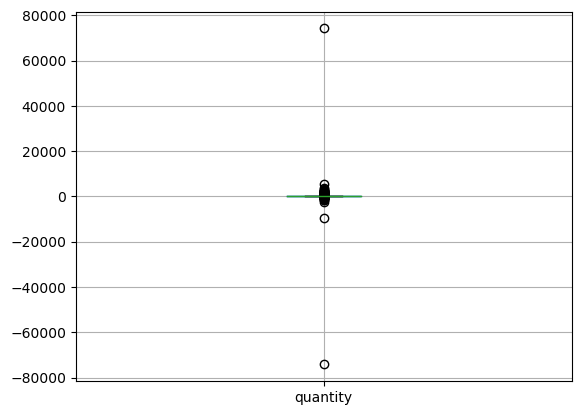

In [20]:
# смотрим диаграму размаха по количеству товаров
retail.boxplot(column='quantity')
plt.show()

Однозначно есть выброс в количестве больше 6тысяч с плюсом и минусом. Это явная ошибка. Но посмотрим диаграмму размаха в большем масштабе.

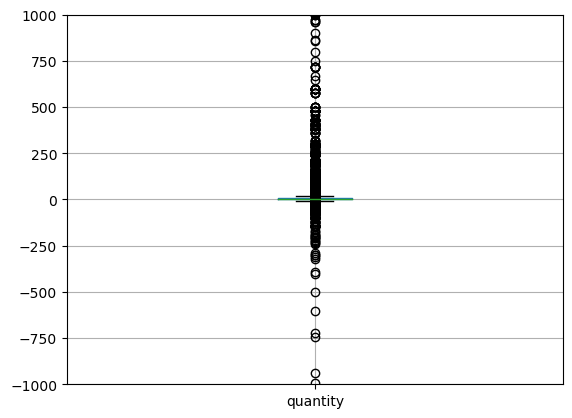

In [21]:
# увеличим масштаб графика
retail.boxplot(column='quantity')
plt.ylim(-1000, 1000)
plt.show()

Похоже что разброс по количеству очень большой. Возможно мелкие детали продают не упаковками, а поштучно. Удалять все данные больше "усов" в данной ситуации считаю нецелесообразным, это исказит картину. К тому же в нашем исследовании количество товара не является ключевым показателем. Можно обрезать только явно выбивающиеся данные больше 1 тысячи и проверить, не потеряли ли мы слишком много данных.

In [22]:
# обрезаем количество меньше -1000 и больше 1000
retail = retail[(retail['quantity'] > -1000) & (retail['quantity'] < 1000)]

# проверяем, не сильно ли изменилось количество строк
print(len(retail_dataset))
print(len(retail))
print('Потеря данных от первоначального количества составила:', "{:.2%}".format(1 - (len(retail) / len(retail_dataset))))

105335
104263
Потеря данных от первоначального количества составила: 1.02%


Потеря составила 1%, что считается допустимым.

Теперь проверим описание столбца с ценами в данных о товарах.

In [23]:
# посмотрим числовое описание столбца с ценами датасета о товарах
products['price_per_one'].describe()

count     9893.000000
mean        19.601814
std        332.147103
min          0.000000
25%          1.250000
50%          2.550000
75%          5.450000
max      16888.020000
Name: price_per_one, dtype: float64

Здесь тоже присутствуют выбросы: максимальная цена слишком большая и стандартное отклонение значительно превышает среднее. Посмотрим диаграмму размаха.

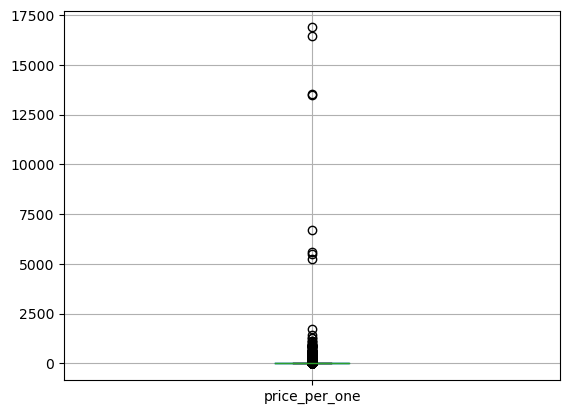

In [24]:
# смотрим диаграму размаха по цене
products.boxplot(column='price_per_one')
plt.show()

Тут замечено несколько выбросов с ценой больше 5 тысяч. Посмотрим поближе

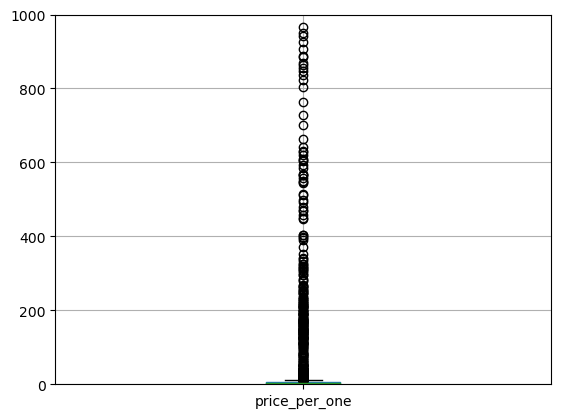

In [25]:
# увеличим масштаб графика
products.boxplot(column='price_per_one')
plt.ylim(0, 1000)
plt.show()

Разброс цен тоже очень большой, но это тоже легко объяснить тем, что в строительном магазине могут быть как очень мелкие детали с низкой стоимостью за единицу товара, так и достаточно крупные и дорогие. Попробуем как и с данными о продажах, обрезать явные выбросы больше 1 тысячи и проверить, не слишком ли много мы потеряли.

In [26]:
# обрезаем стоимость больше 1000
products = products[(products['price_per_one'] < 1000)]

# проверяем, не сильно ли изменилось количество строк
print(len(product_codes))
print(len(products))
print('Потеря данных от первоначального количества составила:', "{:.2%}".format(1 - (len(products) / len(product_codes))))

9969
9878
Потеря данных от первоначального количества составила: 0.91%


Потеря составила меньше 1%, что является допустимым.

<a id='#3'></a>

## Исследовательский анализ данных

### Распределение по датам

Посмотрим, за какой период у нас имеются данные. Для этого сначала добавим столбец без времени, только с датами.

In [27]:
# добавим в данные о продажах столбец с датой
retail['date'] = retail['purchase_date'].dt.date
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
0,538280,21873,11,2016-12-10 12:50:00,18427.0,shop 0,False,2016-12-10
1,538862,22195,0,2016-12-14 14:11:00,22389.0,shop 0,True,2016-12-14
2,538855,21239,7,2016-12-14 13:50:00,22182.0,shop 0,True,2016-12-14
3,543543,22271,0,2017-02-09 15:33:00,23522.0,shop 0,True,2017-02-09
4,543812,79321,0,2017-02-13 14:40:00,23151.0,shop 0,True,2017-02-13


In [28]:
# найдем минимальную имаксимальную дату
print('Минимальная дата:', retail['date'].min())
print('Максимальная дата:', retail['date'].max())

Минимальная дата: 2016-12-01
Максимальная дата: 2017-02-28


У нас есть данные с 1 декабря 2016 года по 28 февраля 2017 года, всего 3 зимних месяца. Посмотрим на гистограмме, как распределены данные внутри этого периода.

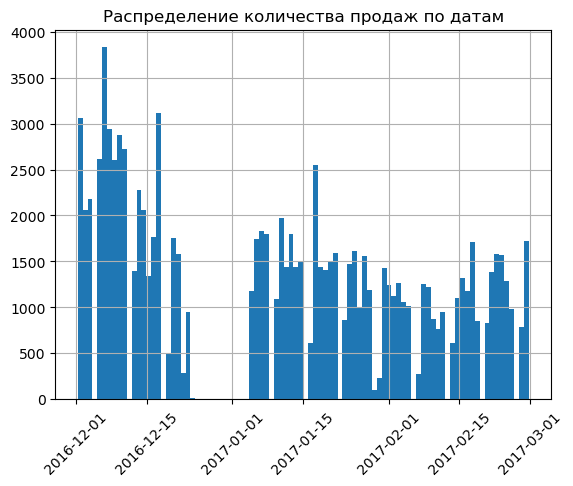

<Figure size 2000x800 with 0 Axes>

In [29]:
# Построим гистограмму распределения количества событий по датам
retail['purchase_date'].hist(bins=92)
plt.xticks(rotation=45)
plt.title('Распределение количества продаж по датам')
plt.figure(figsize=(20, 8))
plt.show();

Распределение выглядит вполне закономерным: есть всплеск покупок перед Новым годом, потом в канун и сам период Нового года провал, что говорит о том, что накануне Нового года мало кто занимается ремонтом. И потом более-менее равномерные продажи с некоторыми пиками и спадами (похоже в зависимости от дней недели) в дальнейший период.

### Распределение количества продаж по магазинам

Посмотрим, как распределены продажи в разных магазинах.

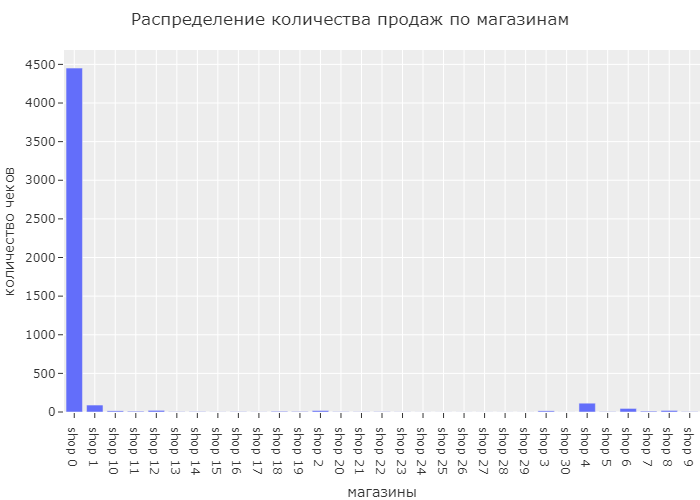

In [30]:
# Построим распределение количества продаж по магазинам
purchases = retail.groupby('shop_id').agg({'purchase_id':'nunique'}).reset_index()

fig = px.bar(purchases, x='shop_id', y='purchase_id')
fig.update_layout(
    title='Распределение количества продаж по магазинам',
    xaxis_title='магазины',
    yaxis_title='количество чеков',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

Нулевой магазин явно выбивается из общего количества. Либо это какой-то центральный магазин, либо распределительный центр или оптовый склад. Увеличим масштаб, чтобы рассмотреть продажи в остальных магазинах.

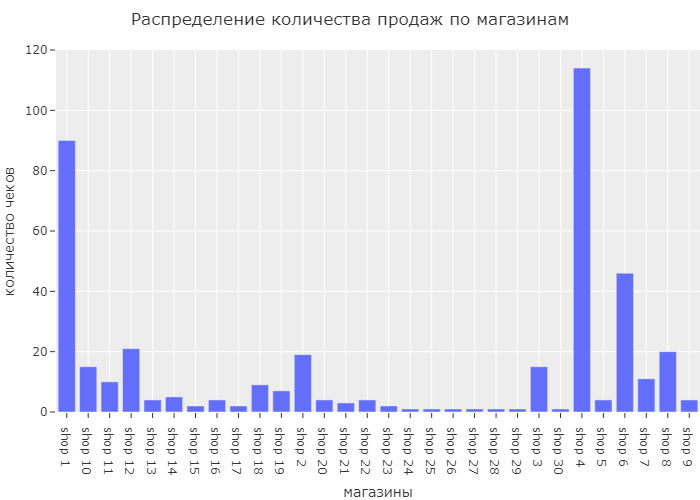

In [31]:
small_purchases = retail.query('shop_id != "shop 0"').groupby('shop_id').agg({'purchase_id':'nunique'}).reset_index()

fig = px.bar(small_purchases, x='shop_id', y='purchase_id')
fig.update_layout(
    title='Распределение количества продаж по магазинам',
    xaxis_title='магазины',
    yaxis_title='количество чеков',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

В остальных магазинах продажи есть, но в некоторых они совсем незначительные.

### Количество покупок по пользователям

Посмотрим, сколько у нас всего имеется уникальных пользователей

In [32]:
# посчитаем количество пользователей
print('Количество уникальных пользователей:', retail['customer_id'].nunique())

Количество уникальных пользователей: 2486


Помним, что в данных о пользователях у нас было много пропусков, которые мы заполнили исходя из логики, что каждый новый чек воспринимается как новый покупатель. Попробуем посмотреть по количеству чеков на человека.

In [33]:
# посчитаем количество пользователей
print('Количество чеков:', retail['purchase_id'].nunique())
# сколько в среднем приходится чеков на одного пользователя с номером айди
print('Среднее количество чеков на одного пользователя:', round(retail['purchase_id'].nunique() / retail['customer_id'].nunique()))

Количество чеков: 4874
Среднее количество чеков на одного пользователя: 2


У нас в данных есть большое количество товаров с отрицательным количеством. Думаю это возвраты. Попробуем посмотреть внимательнее на отрицательные данные.

In [34]:
# смотрим минимум в столбце с количеством
retail.sort_values(by='quantity').head(10)

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
79838,540638,72038p,-991,2017-01-10 12:14:00,540638,shop 0,False,2017-01-10
910,540241,35957,-940,2017-01-05 15:17:00,540241,shop 0,False,2017-01-05
21912,544410,84997c,-742,2017-02-18 13:54:00,544410,shop 0,False,2017-02-18
2583,538090,20956,-724,2016-12-09 14:48:00,538090,shop 0,False,2016-12-09
28821,c542693,15036,-601,2017-01-31 12:36:00,18587.0,shop 0,False,2017-01-31
57652,c539329,85123a,-501,2016-12-17 09:37:00,21692.0,shop 0,False,2016-12-17
50809,544649,21621,-401,2017-02-22 12:37:00,544649,shop 0,False,2017-02-22
63947,543262,84614a,-391,2017-02-04 16:08:00,543262,shop 0,False,2017-02-04
97842,537028,21696,-321,2016-12-03 16:36:00,537028,shop 0,False,2016-12-03
91455,540978,84050,-311,2017-01-12 15:04:00,540978,shop 0,False,2017-01-12


Посмотрим теперь по покупателям, чей номер айди среди этих возвратов нам известен.

In [35]:
# пробуем посмотреть покупателя с самым большим отрицательным числом в количестве
retail.query('customer_id == 18587.0')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
28821,c542693,15036,-601,2017-01-31 12:36:00,18587.0,shop 0,False,2017-01-31
99360,542694,15036,599,2017-01-31 12:37:00,18587.0,shop 0,False,2017-01-31


In [36]:
# и еще один
retail.query('customer_id == 21692.0').sort_values(by='item_id')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
17080,543674,15056n,119,2017-02-11 11:28:00,21692.0,shop 0,False,2017-02-11
94797,c539329,20733,-301,2016-12-17 09:37:00,21692.0,shop 0,False,2016-12-17
88538,539331,20733,299,2016-12-17 09:39:00,21692.0,shop 0,False,2016-12-17
93865,539109,20733,299,2016-12-16 11:07:00,21692.0,shop 0,False,2016-12-16
43476,543674,21471,95,2017-02-11 11:28:00,21692.0,shop 0,False,2017-02-11
67230,543673,22423,31,2017-02-11 11:28:00,21692.0,shop 0,False,2017-02-11
66023,540401,22423,47,2017-01-07 09:31:00,21692.0,shop 0,False,2017-01-07
54064,540401,22507,63,2017-01-07 09:31:00,21692.0,shop 0,False,2017-01-07
16113,543673,22507,47,2017-02-11 11:28:00,21692.0,shop 0,False,2017-02-11
48464,543674,47566,99,2017-02-11 11:28:00,21692.0,shop 0,False,2017-02-11


Не вполне понятная история: во-первых, отрицательное количество не совпадает с положительным того же товара. Но это может объясняться покупкой на предыдущем этапе, который не попал в наш исследуемый период. Во-вторых, отрицательное может быть по времени на минуту раньше проведено, чем положительное. Возможно это какие-то особенности проведения через систему/склад. Так же это могут быть комиссии при продаже товаров через маркетплейсы или какие-то кэшбеки по карте. По возможности стоит уточнить у клиента. Мы пока можем оставить как есть.

### Стоимость одного товара

Посмотрим, какое количество цен указано на один товар

In [37]:
# смотрим количество вариантов стоимости для каждого из товаров
products.groupby('product_id').agg({'price_per_one' : 'nunique'}).sort_values(by='price_per_one', ascending=False).head(15)

,price_per_one
product_id,
dot,174
m,53
s,29
post,15
d,13
79321,11
47566,10
84406b,10
22112,9


На один и тот же товар довольно большое количество цен. Сделаем отдельный столбец с медианной стоимостью на каждый товар, чтобы потом по нему можно было добавить цену в столбец с продажами для рассчета столбца с суммой покупок.

In [38]:
# создадим отдельный список с медианной стоимостью каждого товара
median_prices = products.groupby('product_id').agg({'price_per_one' : 'median'}).reset_index()
median_prices.head()

,product_id,price_per_one
0,10002,1.63
1,10080,0.85
2,10120,0.21
3,10123c,0.65
4,10124a,0.42


Добавим в данные о продажах столбец со стоимостью товара

In [39]:
# объединим таблицу о продажах с таблицей медианных цен по айди товара
retail = retail.merge(median_prices, left_on ='item_id', right_on ='product_id')
# удалим задублированный столбец с айди товара
retail =  retail.drop(columns='product_id')
# проверим
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,shop 0,False,2016-12-10,1.63
1,541104,21873,0,2017-01-13 14:29:00,541104,shop 0,False,2017-01-13,1.63
2,540418,21873,1,2017-01-07 11:04:00,540418,shop 0,False,2017-01-07,1.63
3,541516,21873,2,2017-01-18 17:34:00,541516,shop 0,False,2017-01-18,1.63
4,541566,21873,35,2017-01-19 11:50:00,23401.0,shop 0,True,2017-01-19,1.63


Теперь можно будет считать и сравнивать стоимость чека.

<a id='#4'></a>

## Анализ программы лояльности

### Количество участников программы лояльности в разрезе магазинов

Проверим, в каких магазинах больше всего участников программы лояльности

In [40]:
# сохраним в отдельный список только данные с программой лояльности
loyalty = retail.query('loyalty_program == True')
loyalty.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,price_per_one
4,541566,21873,35,2017-01-19 11:50:00,23401.0,shop 0,True,2017-01-19,1.63
7,543592,21873,5,2017-02-10 11:57:00,22922.0,shop 0,True,2017-02-10,1.63
11,542608,21873,0,2017-01-30 13:51:00,22449.0,shop 0,True,2017-01-30,1.63
17,539252,21873,35,2016-12-16 14:17:00,23423.0,shop 0,True,2016-12-16,1.63
20,544930,21873,0,2017-02-24 18:26:00,23151.0,shop 0,True,2017-02-24,1.63


In [41]:
# выведем количество уникальных пользователей с программой лояльности в каждом из магазинов
loyalty_by_shop = loyalty.groupby('shop_id').agg({'customer_id':'nunique'}).sort_values(by='customer_id', ascending=False).reset_index()
loyalty_by_shop

,shop_id,customer_id
0,shop 0,583
1,shop 19,1
2,shop 28,1
3,shop 8,1


Получается, что только 4 магазина участвуют в программе лояльности. Причем в трех из них только по одному пользователю карты лояльности и только в самом крупном нулевом магазине 583 участника. В таком случае имеет смысл анализировать эффективность программы лояльности только по нулевому магазину, чтобы получить достоверную картину. Сохраним данные об этом магазине в отдельный датафрейм.

In [42]:
# сохраним для анализа данные только о нулевом магазине
shop_0 = retail.query('shop_id == "shop 0"')
shop_0.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,shop 0,False,2016-12-10,1.63
1,541104,21873,0,2017-01-13 14:29:00,541104,shop 0,False,2017-01-13,1.63
2,540418,21873,1,2017-01-07 11:04:00,540418,shop 0,False,2017-01-07,1.63
3,541516,21873,2,2017-01-18 17:34:00,541516,shop 0,False,2017-01-18,1.63
4,541566,21873,35,2017-01-19 11:50:00,23401.0,shop 0,True,2017-01-19,1.63


### Количество участников программы лояльности в динамике

Посмотрим, как менялось количество покупателей с картой лояльности внутри исследуемого периода.

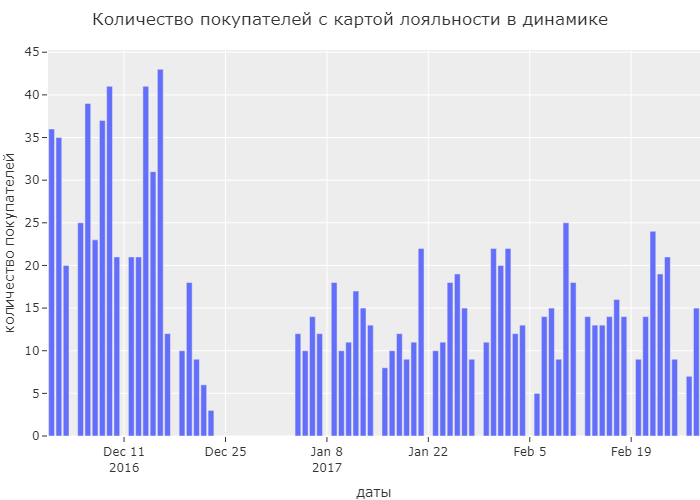

In [43]:
# Посмотрим изменение количества покупателей с картой лояльности по датам
df = shop_0.query('loyalty_program == True').groupby('date').agg({'customer_id':'nunique'}).reset_index()

fig = px.bar(df, x='date', y='customer_id')
fig.update_layout(
    title='Количество покупателей с картой лояльности в динамике',
    xaxis_title='даты',
    yaxis_title='количество покупателей',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

На графике видно, что количество участников программы лояльности в 2016 году было больше, чем в 2017. Отсутствие покупателей в конце декабря и начале января говорит о том, что в новогодние праздники магазин не работал, после чего количество снова выросло, но уже не так сильно, как было в первой половине декабря. Кроме того видно, что магазин так же не работает по воскресеньям.

### Сравнение количества и доли покупателей с программой лояльности и без в динамике

Посмотрим, как менялось количество покупателей с картой лояльности и без за исследуемый период 

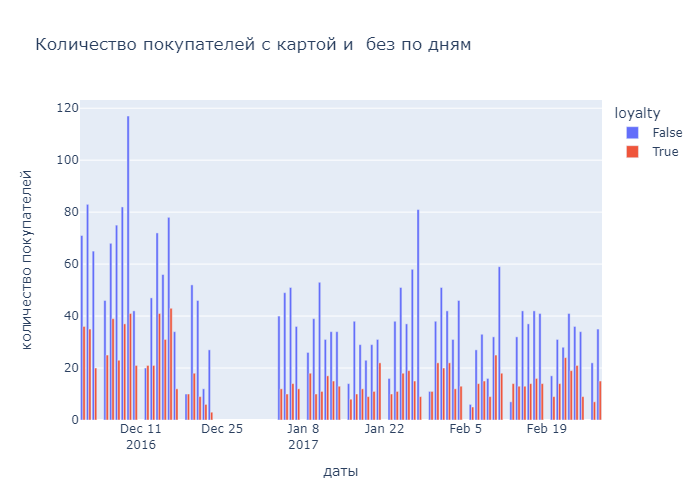

In [44]:
# подготовим данные
data = shop_0.pivot_table(index=['date', 'loyalty_program'], values='customer_id', aggfunc='nunique').reset_index()
data.columns = ['date', 'loyalty', 'count_customers']

# строим диаграмму
fig = px.bar(data, x="date", y="count_customers", color="loyalty", title="Количество покупателей с картой и  без по дням", barmode='group')
fig.update_layout(xaxis_title='даты', yaxis_title='количество покупателей')
fig.show()

На первый взгляд количество покупателей с картой лояльности изменяется примерно пропорционально изменению количество покупателей без карты.
Но для уверенности посмотрим на график относительного количества участников программы лояльности ко всем покупателям в динамике.

In [45]:
# посчитаем количество покупателей всего по дням
all_customers = shop_0.groupby('date').agg({'customer_id':'nunique'}).reset_index()
all_customers.columns=['date', 'all_customers']

# посчитаем количество пользователей программы лояльности по дням
loyalty_customers = shop_0.query('loyalty_program == True').groupby('date').agg({'customer_id':'nunique'}).reset_index()
loyalty_customers.columns=['date', 'loyalty_customers']

# Объединим таблицы
customers_data = loyalty_customers.merge(all_customers, on='date', how='outer')
# добавим столбец с долей участников программы лояльности по дням
customers_data['share'] = customers_data['loyalty_customers'] / customers_data['all_customers']
customers_data.head()

,date,loyalty_customers,all_customers,share
0,2016-12-01,36,107,0.336449
1,2016-12-02,35,118,0.296610
2,2016-12-03,20,85,0.235294
3,2016-12-05,25,71,0.352113
4,2016-12-06,39,107,0.364486


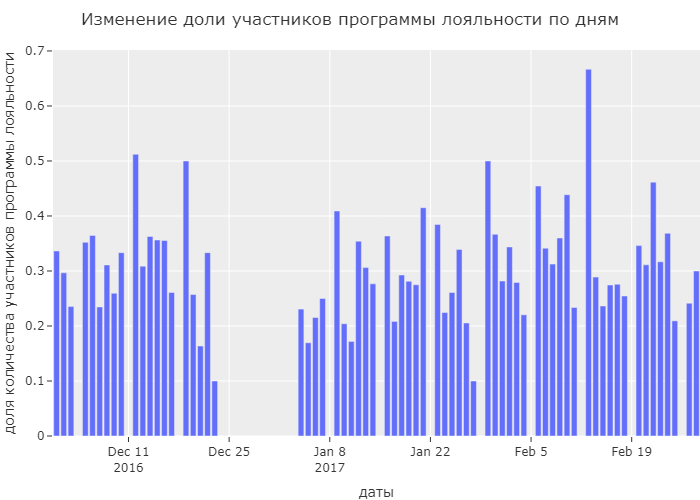

In [46]:
# Построим график
fig = px.bar(customers_data, x='date', y='share')
fig.update_layout(
    title='Изменение доли участников программы лояльности по дням',
    xaxis_title='даты',
    yaxis_title='доля количества участников программы лояльности',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

Динамика количества пользователей с картой лояльности примерно повторяет динамику остальных пользователей, только чуть сглаженную. Точно так же нет покупок в Новогодние праздники и по воскресеньям. В остальном в среднем доля участников программы лояльности стабильная и составляет около 25-30%.

### Количество чеков на покупателя среди участников программы лояльности и остальных

Сравним среднее количество чеков на одного покупателя среди пользователей системы лояльности и остальных.

In [47]:
# считаем количество чеков на каждого покупателя
purchases = shop_0.groupby(['customer_id', 'loyalty_program']).agg({'purchase_id':'nunique'}).reset_index()
# считаем среднее количество чеков на покупателя с картой и без
mean_purchases = purchases.groupby('loyalty_program').agg({'purchase_id':'mean'}).reset_index()
mean_purchases

,loyalty_program,purchase_id
0,False,1.818659
1,True,2.286449


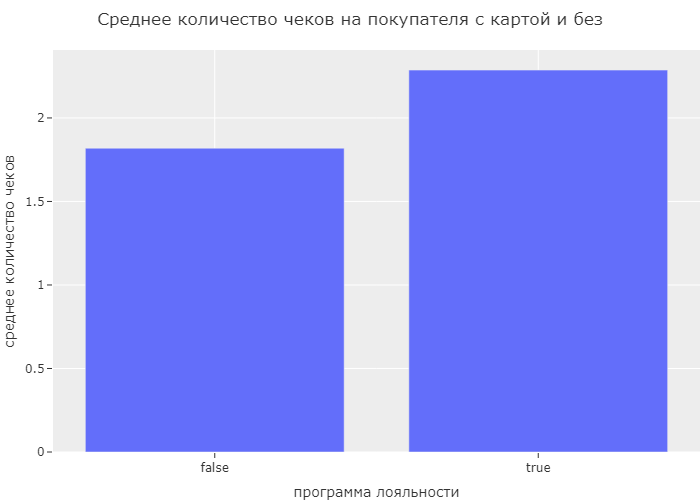

In [48]:
# строим столбчатую диаграмму
fig = px.bar(mean_purchases, x='loyalty_program', y='purchase_id')
fig.update_layout(
    title='Среднее количество чеков на покупателя с картой и без',
    xaxis_title='программа лояльности',
    yaxis_title='среднее количество чеков',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

В среднем на одного покупателя с картой лояльности приходится чеков больше, чем на покупателя без карты лояльности. Но нужно помнить, что мы не всех покупателей без карты лояльности смогли идентифицировать, и считали каждый новый чек как нового покупателя. Возможно среди них были и повторные покупки. Но все равно ожидаемо, что человек с картой лояльности будет возвращаться с большей вероятностью, чем без карты.

Проверим наши догадки и посмотрим среднее количество чеков на одного покупателя до того, как заполнили недостающие данные с айди покупателя.

In [49]:
empty_retail.groupby(['customer_id', 'loyalty_program']).agg({'purchase_id':'nunique'}).reset_index().groupby('loyalty_program').agg({'purchase_id':'mean'}).reset_index()

,loyalty_program,purchase_id
0,0.0,2.411360
1,1.0,2.289608


Среднее количество чеков среди покупателей без карты лояльности увеличилось с 1,81 до 1,85, что совсем незначительно.

### Медианная сумма чека среди участников программы лояльности и остальных покупателей

Сравним теперь среднюю сумму чеков среди покупателей с картой лояльности и остальных. Поскольку у нас большой разброс в стоимости товаров, лучше брать для расчета медианную стоимость.
Для этого подготовим данные: сначала добавим колонку с суммой товара и затем посчитаем сумму каждого чека.

In [50]:
# добавляем колонку со стоимостью продукта
shop_0['cost'] = shop_0['price_per_one'] * shop_0['quantity']

# считаем суммму каждого чека
sum_purchase = shop_0.groupby(['purchase_id', 'loyalty_program']).agg({'cost':'sum'}).reset_index()

#считаем медианную сумму чека среди покупателей с картой лояльности и без
median_sum_purchase = sum_purchase.groupby('loyalty_program').agg({'cost':'median'}).reset_index()
median_sum_purchase

,loyalty_program,cost
0,False,174.355
1,True,218.360


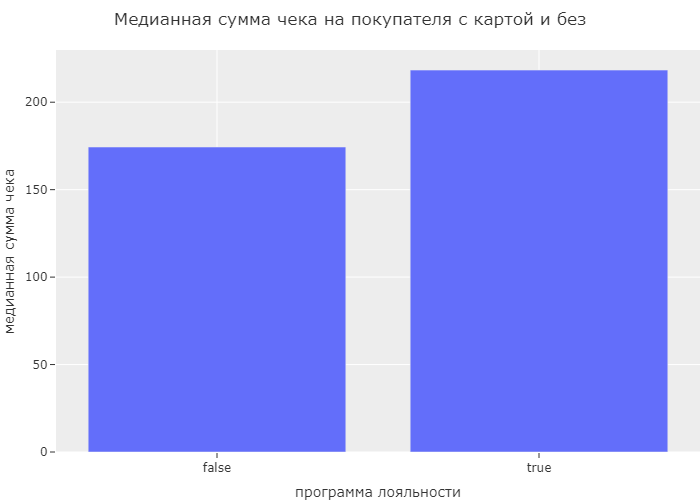

In [51]:
# строим столбчатую диаграмму
fig = px.bar(median_sum_purchase, x='loyalty_program', y='cost')
fig.update_layout(
    title='Медианная сумма чека на покупателя с картой и без',
    xaxis_title='программа лояльности',
    yaxis_title='медианная сумма чека',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

Медианная сумма чека среди пользователей карты лояльности составила почти 224 рубля, а среди остальный покупателей 177 рублей. Разница не очень большая, но все же пользователи карты лояльности в среднем делают покупки на большую сумму, либо возвращают меньше товаров, чем покупатели без карты лояльности.

In [52]:
#код тимлида
sum_purchase_look = shop_0[shop_0['cost'] > 0].groupby(['purchase_id', 'loyalty_program']).agg({'cost':'sum'}).reset_index()

median_sum_purchase_look = sum_purchase_look.groupby('loyalty_program').agg({'cost':'median'}).reset_index()
median_sum_purchase_look

,loyalty_program,cost
0,False,334.62
1,True,296.70


### Динамика среднего чека среди участников программы лояльности и остальных

Посмотрим, как менялся средний чек во времени среди участников программы лояльности и остальный покупателей.

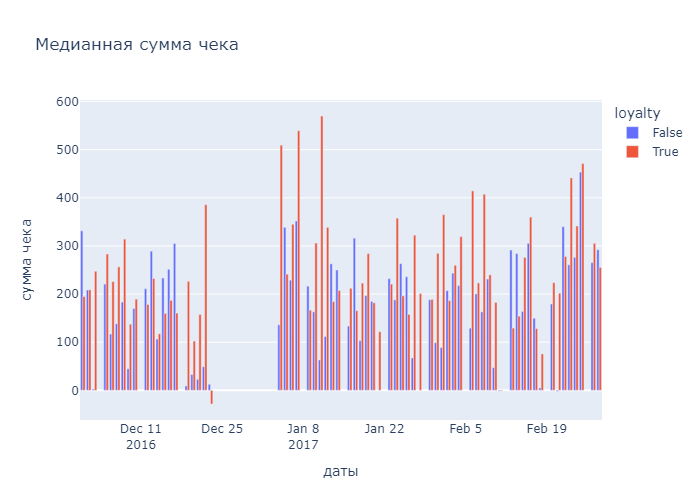

In [53]:
# считаем сумму чеков по датам
sum_purchase_by_date = shop_0.groupby(['date','purchase_id', 'loyalty_program']).agg({'cost':'sum'}).reset_index()
# считаем медианную сумму чека по датам в зависимости от программы лояльности
median_purchase_by_date = sum_purchase_by_date.pivot_table(index=['date','loyalty_program'], values='cost', aggfunc='median').reset_index()
median_purchase_by_date.columns = ['date', 'loyalty', 'median_purchase']

fig = px.bar(median_purchase_by_date, x="date", y="median_purchase", color="loyalty", title="Медианная сумма чека", barmode='group')
fig.update_layout(xaxis_title='даты', yaxis_title='сумма чека')
fig.show();

Медианная сумма чека стабильно выше среди покупателей с картой лояльности. Самая большая разница была зафиксирована в начале января: покупатели с картой лояльности быстрее возвращаются после новогодних праздников и сразу покупают на большую сумму по сравнению с остальными покупателями. Так же в конце января замечено, что динамика участников программы лояльности и остальных идет в противофазе: когда приходит больше всего покупателей с картой, тогда у остальных меньше и наоборот. В остальной период такого эффекта нет. Возможно в этот период проходила какая-то маркетинговая акция и активно привлекали в магазине к участию в программе лояльности: так что простые покупатели принимали участие в программе и переходили в разряд участников.

### Медианное количество товаров в чеке среди участников программы и остальных покупателей

In [54]:
# считаем количество товаров в чеке
items_in_purchase = shop_0.groupby(['loyalty_program', 'purchase_id']).agg({'quantity':'sum'}).reset_index()
items_in_purchase
# считаем медианное количество товаров в чеке среди участников программы лояльности и нет
mean_items_in_purchase = items_in_purchase.groupby('loyalty_program').agg({'quantity':'median'}).reset_index()
mean_items_in_purchase

,loyalty_program,quantity
0,False,56.0
1,True,75.0


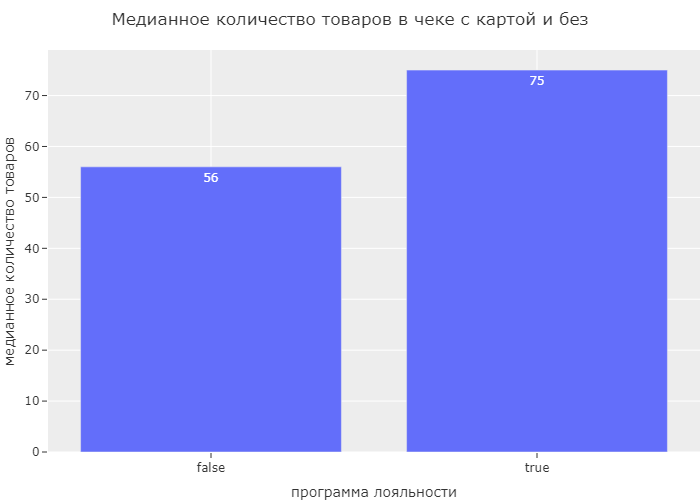

In [55]:
# строим столбчатую диаграмму
fig = px.bar(mean_items_in_purchase, x='loyalty_program', y='quantity', text='quantity')
fig.update_layout(
    title='Медианное количество товаров в чеке с картой и без',
    xaxis_title='программа лояльности',
    yaxis_title='медианное количество товаров',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

Покупатели с картой лояльности в среднем за одну покупку берут 75 позиций, тогда как покупатели без карты в среднем 56.

### Топ-5 товаров среди участников программы лояльности и остальных покупателей

Посмотрим, являются ли самые популярные товары среди участников программы лояльности и остальных одинаковыми.

In [56]:
# найдем топ-5 айди продуктов среди участников программы лояльности
top_loyalty = (
    retail
    .query('loyalty_program == True')
    .groupby('item_id')
    .agg({'quantity':'sum'})
    .sort_values(by='quantity', ascending=False)
    .head(5)
    .reset_index()
)
top_loyalty

,item_id,quantity
0,17003,3406
1,22197,2952
2,22616,2894
3,22189,2141
4,21623,2031


In [57]:
# Теперь найдем топ-5 продуктов среди покупателей без карты лояльности
top_other = (
    retail
    .query('loyalty_program == False')
    .groupby('item_id')
    .agg({'quantity':'sum'})
    .sort_values(by='quantity', ascending=False)
    .head(5)
    .reset_index()
)
top_other

,item_id,quantity
0,21212,6431
1,85099b,5999
2,85123a,5322
3,22355,4007
4,22197,3966


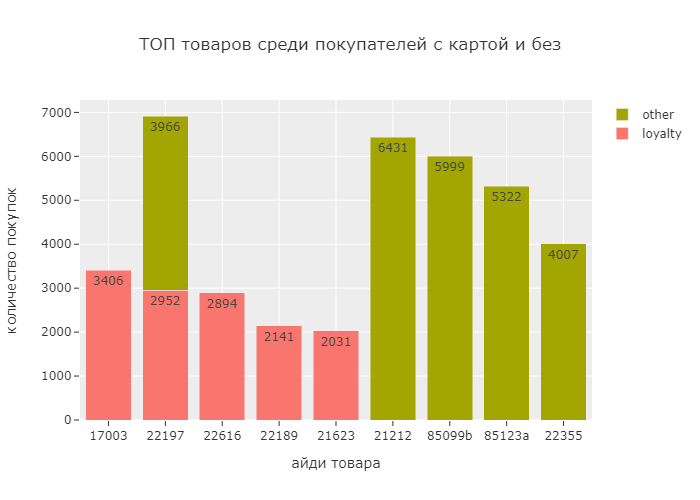

In [58]:
# посмотрим на диаграмме, совпадают ли самые популярные товары среди участников программы лояльности и остальных
fig = go.Figure(data=[
    go.Bar(name='loyalty', x=top_loyalty['item_id'], y=top_loyalty['quantity'], text=top_loyalty['quantity']),
    go.Bar(name='other', x=top_other['item_id'], y=top_other['quantity'], text=top_other['quantity'])
])
# Change the bar mode
fig.update_layout(
    barmode='stack', 
    title_text='ТОП товаров среди покупателей с картой и без', 
    xaxis_title='айди товара',
    yaxis_title='количество покупок',
    template = 'ggplot2'
)
fig.show();

Только один продукт попал в топ-5 самых покупаемых товаров среди обеих групп: покупателей с картой лояльности и без. Остальные продукты отличаются.

### Динамика доли прибыли от участников программы лояльности

Теперь посмотрим, как менялась во времени доля прибыли участников программы лояльности относительно всей прибыли.

In [59]:
# Посчитаем общую сумму покупок по дням
everyday_profit = shop_0.groupby('date').agg({'cost':'sum'}).reset_index()
everyday_profit.columns=['date', 'total_profit']

# Посчитаем прибыль от участников программы лояльности по дням
loyalty_profit = shop_0.query('loyalty_program == True').groupby('date').agg({'cost':'sum'}).reset_index()
loyalty_profit.columns=['date', 'loyalty_profit']

# Объединим таблицы с прибылью
profit_data = everyday_profit.merge(loyalty_profit, on='date', how='outer')
# добавим столбец с долей участников программы лояльности по дням
profit_data['share'] = profit_data['loyalty_profit'] / profit_data['total_profit']
profit_data.head()

,date,total_profit,loyalty_profit,share
0,2016-12-01,64101.390,14445.815,0.225359
1,2016-12-02,60060.765,16921.885,0.281746
2,2016-12-03,30231.685,8827.515,0.291995
3,2016-12-05,28671.475,10707.625,0.373459
4,2016-12-06,44734.375,15555.725,0.347735


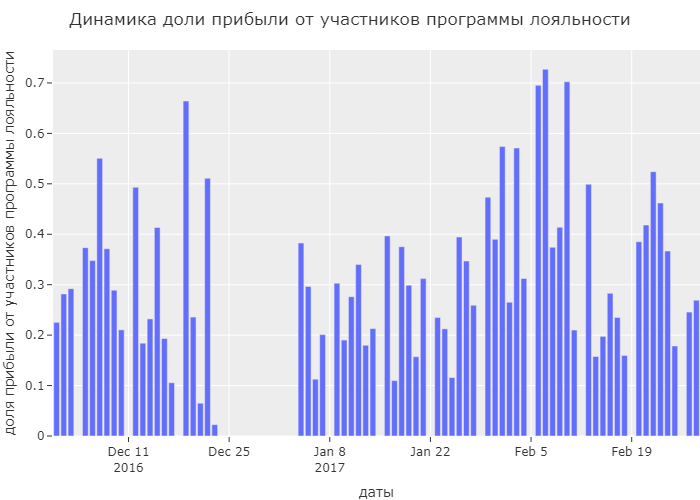

In [60]:
# Построим график

fig = px.bar(profit_data, x='date', y='share')
fig.update_layout(
    title='Динамика доли прибыли от участников программы лояльности',
    xaxis_title='даты',
    yaxis_title='доля прибыли от участников программы лояльности',
    margin=dict(l=0, r=0, t=50, b=0),
    template = 'ggplot2'
)
fig.show();

Доля прибыли тоже имеет очень нестабильный вид.

<a id='#5'></a>

## Проверка гипотезы о том, что средний чек участников программы лояльности выше, чем у остальных

**Нулевая гипотеза**: средний чек участников программы лояльности и остальных покупателей одинаковый

**Альтернативная гипотеза**: средний чек участников программы лояльности выше, чем у остальных покупателей.

**уровень статистической значимости**: 5%

In [61]:
# Подготовим данные
loyalty = shop_0.query('loyalty_program == True').groupby('purchase_id').agg({'cost':'sum'})
other = shop_0.query('loyalty_program == False').groupby('purchase_id').agg({'cost':'sum'})

# results = вызов метода для проверки гипотезы
# поскольку выборки разного размера, указываем equal_var как False
results = st.ttest_ind(loyalty, other, equal_var=False)

# задаем значение уровня значимости
alpha = .05

# вывод значения p-value на экран 
print('p-значение:', results.pvalue/2)

# условный оператор с выводом строки с ответом
if results.pvalue/2 < alpha and (loyalty.mean() > other.mean()):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: [0.3374146]
Не получилось отвергнуть нулевую гипотезу


Гипотеза о том, что средний чек у участников программы лояльности выше, не подтвердилась. Это значит, что средний чек может быть такой же или ниже.

<a id='#6'></a>

## Проверка гипотезы о том, что среднее количество товаров в чеке среди участников программы лояльности выше, чем у остальных

**Нулевая гипотеза**: среднее количество товаров в чеке у участников программы лояльности и остальных покупателей одинаковое

**Альтернативная гипотеза**: среднее количество товаров в чеке у участников программы лояльности выше, чем у остальных покупателей.

**уровень статистической значимости**: 5%

In [62]:
# Подготовим данные
loyalty = shop_0.query('loyalty_program == True').groupby('purchase_id').agg({'quantity':'sum'})
other = shop_0.query('loyalty_program == False').groupby('purchase_id').agg({'quantity':'sum'})

# results = вызов метода для проверки гипотезы
# поскольку выборки разного размера, указываем equal_var как False
results = st.ttest_ind(loyalty, other, equal_var=False)

# задаем значение уровня значимости
alpha = .05

# вывод значения p-value на экран 
print('p-значение:', results.pvalue/2)

# условный оператор с выводом строки с ответом
if results.pvalue/2 < alpha and (loyalty.mean() > other.mean()):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: [0.12443404]
Не получилось отвергнуть нулевую гипотезу


И эта гипотеза тоже не подтвердилась: среднее количество товаров в чеке среди участников программы лояльности и остальных покупателей может быть как одинаковое, так и меньшим среди пользователей карты.

<a id='#7'></a>

## Выводы

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid black 2px; padding: 20px">
У нас в наличии были данные о покупках в сети розничных строительных магазинов за 3 зимних месяца 2016-2017 годов. В одном файле были указаны товары с ценами, а во втором данные о покупках включая информацию об участии в программе лояльности.
Примерно в трети данных о покупках отсутствовала информация с номером покупателя: мы исправили отсутствующие данные прировняв каждую отдельную покупку к новому пользователю.
В информации о ценах на товары было несколько вариантов на каждый товар. Для анализа суммы чеков были взяты медианные значения стоимости по каждому товару.
Кроме того в данных о количестве товаров в чеке присутствовало много отрицательных значений и нулей. Анализ показал, что это только частично могут быть возвраты, а остальное либо комиссии банков или маркетплейсов, либо что-то типа кэшбека.

Исследовательский анализ данных показал, что в начале декабря были самые большие продажи, которые упали почти до нуля в канун Нового года, но потом к середине января повысились, хоть и не до предыдущего уровня. Так же имеются колебания примерно каждую неделю, что может быть связано с тем, что по выходным обычно совершают больше покупок, чем в будни.

Анализ данных в разрезе магазинов показал, что участники программы лояльности есть только в четырех магазинах из 11, при этом в трех из них только по одному покупателю с картой лояльности. Поэтому было принято решение для анализа программы лояльности брать данные только по одному магазину, где участников программы достаточно для анализа. Кроме того продажи в этом магазине сильно отличаются от остальных количеством: либо это склад или какой-то центральный магазин, либо он работает дольше всего, а остальные, возможно, только недавно открылись.

Что касается анализа программы лояльности, то он показал, что доля покупателей с картой лояльности имеет скачкообразный характер, но без тенденции к увеличению или уменьшению, и составляет в среднем 30% от общего количества покупателей. Медианное количество чеков на участника программы лояльности получилось чуть выше, чем на остальных пользователей (2,3 против 1,8 на одного человека). Медианная сумма чека тоже немного выше среди участников программы: 224 рубля у участников и 177 рублей у остальных покупателей. Медианное количество товаров в чеке так же у покупателей с картой лояльности чуть выше: 75 против 56 без карты. Состав самых популярных товаров среди участников программы лояльности и остальных сильно отличается: только один товар попал в топ-5 обеих групп. Доля прибыли от участников программы лояльности нестабильна, как и количество участников, но в среднем составляет около 30%. В динамике доли прибыли заметны несколько резких провалов с уходом в минус: это говорит о том, что данные с отрицательными значениями в количестве товаров (то есть возможно возвраты или комиссии) в некоторые дни превысили сумму покупки. Возможно стоит для подобного анализа исключать информацию о комиссиях. 

Кроме того, если в программу лояльности включены льготы на возврат товаров, то стоит, возможно, пересмотреть политику возвратов, чтобы не провоцировать покупателей на дополнительные возвраты и предусмотреть какой-то другой бонус для сохранения интереса к программе лояльности без ущерба для компании.

Проверка гипотезы о том, что средний чек и среднее количество товаров в чеке среди покупателей с картой лояльности выше, не прошла подтверждение. Сатистическая значимость в 5% не была достигнута. Но есть вероятность, что при исключении из данных отрицательных значений, которые не относятся к покупкам, ситуация может измениться.
___________________